In [102]:
from dotenv import load_dotenv
from typing import Annotated, List
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from PIL import Image 

from typing import List, Optional
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langgraph.graph import END, StateGraph, START

import functools
import operator

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from typing_extensions import TypedDict
from langchain_core.runnables.history import RunnableWithMessageHistory
import base64
import os
from langgraph.checkpoint import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.prebuilt import create_react_agent
from langchain_core.runnables import RunnableLambda

load_dotenv() 

from langchain.memory import ChatMessageHistory
from langgraph.checkpoint.aiosqlite import AsyncSqliteSaver


os.environ["LANGCHAIN_PROJECT"] = "pr-this-experiment-22"

In [103]:
pip install aiosqlite


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [104]:
@tool
def clickNewImage() ->  str : 
    """Use camera to take picture of the current scenario and gives you the image path """ 
    return "demo.jpeg"

def encoded_image(image_path): 
    with open(image_path, "rb") as image_file:
        image_data = image_file.read()
        encoded_image = base64.b64encode(image_data).decode("utf-8")
        return encoded_image 


@tool
def VisualQuestionAnswer(query: str, image_path : str) -> str:
    """ Takes a query which is the question users asks about the image and image_path which is the path of the image""" 
    with open(image_path, "rb") as image_file:
        image_data = image_file.read()
        encoded_image = base64.b64encode(image_data).decode("utf-8")
    
    prompt =  [
        HumanMessage(
            content=[
                {"type": "text", "text": query},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{encoded_image}"
                    },
                },
            ],
        ),
    ]
    model = ChatOpenAI(model="gpt-4o")
    return model.invoke(prompt) 
    
# VisualQuestionAnswer(query = "what is this picture about", image_path = "cats.jpg")

In [105]:
tools_for_VLM = [VisualQuestionAnswer, clickNewImage]

In [106]:
class VisionLanguageTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    
    team_members: List[str]
    
    next: str
vision_language_agent_prompt = "You are a Vision Language assistant who can answer based on images. It has 2 tools - clickNewImage which can be called when you want to take a new image, VisualQuestionAnswer when you want to generically answer any question. "

In [107]:
def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += "\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason! You are one of the following team members: {team_members}."
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}


In [108]:
llm = ChatOpenAI(model="gpt-4-1106-preview")

vision_language_agent = create_agent(
    llm,
    tools_for_VLM,
    vision_language_agent_prompt,
)

vision_language_node = functools.partial(agent_node, agent=vision_language_agent, name="Vision_Language_Agent")

In [109]:
## dummy nodes for language and video agent 

tavily_tool = TavilySearchResults(max_results=5)

language_agent_prompt = "You are a language assistant who can give you answers based on just text. If you get a final answer summarise the answer. " 
language_agent = create_agent(
    llm,
    [tavily_tool],
    language_agent_prompt,
)

language_agent_node = functools.partial(agent_node, agent=language_agent, name="Language_Agent")


video_agent_prompt = "You are a video assistant who can give you answers based on videos. This agent will only be called when to answer for a query we need a video to process. If you get a final answer summarise the answer" 
video_agent = create_agent(
    llm,
    [],
    video_agent_prompt,
)

video_agent_node = functools.partial(agent_node, agent=video_agent, name="Video_Agent")

In [110]:
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  Vision Language Agent, Video Agent and Language Agent. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH and just summarise the result.",
    ["Language_Agent","Vision_Language_Agent", "Video_Agent"],
)

In [114]:
agent_graph = StateGraph(VisionLanguageTeamState)
agent_graph.add_node("Vision_Language_Agent", vision_language_node)
agent_graph.add_node("Video_Agent", video_agent_node)
agent_graph.add_node("Language_Agent", language_agent_node)
agent_graph.add_node("supervisor", supervisor_agent)

agent_graph.add_edge("Language_Agent", "supervisor")
agent_graph.add_edge("Vision_Language_Agent", "supervisor")
agent_graph.add_edge("Video_Agent", "supervisor")
agent_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Vision_Language_Agent": "Vision_Language_Agent", "Language_Agent": "Language_Agent","Video_Agent": "Video_Agent", "FINISH": END},
)

# memory = AsyncSqliteSaver.from_conn_string(":memory:")
checkpointer = MemorySaver()

agent_graph.add_edge(START, "supervisor")
chain = agent_graph.compile(checkpointer=checkpointer)


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


# research_chain = enter_chain | chain
research_chain = chain 

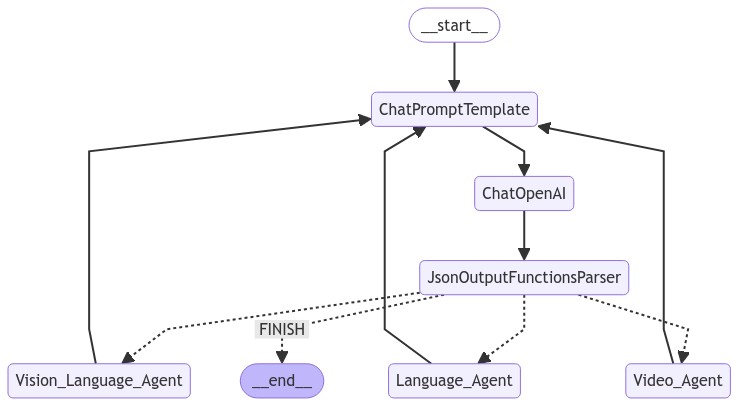

In [116]:
from IPython.display import Image, display

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))

In [120]:
# config = {"configurable": {"thread_id": "2"}}

# for s in research_chain.stream(
#     {"messages": [input_message]},
#     {"recursion_limit": 100}
# ):
#     if "__end__" not in s:
#         print(s)
#         print("---")
for s in research_chain.stream(
    {"messages": [HumanMessage(content="What is infront of me ?")]},
    config={"configurable": {"thread_id": 42}}
): 
    if "__end__" not in s:
        print(s)
        print("---")


{'supervisor': {'next': 'Vision_Language_Agent'}}
---
{'Vision_Language_Agent': {'messages': [HumanMessage(content='In front of you is a person in a kitchen preparing food. They are holding a bowl and appear to be adding chopped vegetables to it. The countertop in front of them has various vegetables, including carrots and leafy greens. The person is wearing an apron, which suggests that they are cooking or preparing a meal.', name='Vision_Language_Agent')]}}
---
{'supervisor': {'next': 'FINISH'}}
---


In [121]:
for s in research_chain.stream(
    {"messages": [HumanMessage(content="what can i make using these? ")]},
    config={"configurable": {"thread_id": 42}}
): 
    if "__end__" not in s:
        print(s)
        print("---")



{'supervisor': {'next': 'Language_Agent'}}
---
{'Language_Agent': {'messages': [HumanMessage(content="Based on the vegetables you mentioned—carrots and leafy greens—here are some meal ideas you can consider making:\n\n1. **Salad**: Create a fresh and healthy salad by chopping up the carrots and leafy greens and adding your favorite dressing. You can also include other ingredients like nuts, seeds, fruits, cheese, or croutons for added flavor and texture.\n\n2. **Stir-fry**: Make a quick and nutritious stir-fry by sautéing the chopped vegetables in a pan with some oil. You can add protein like tofu, chicken, beef, or shrimp and serve it over rice or noodles.\n\n3. **Soup**: Cook a comforting vegetable soup by simmering the carrots and leafy greens in a broth with other vegetables like onions, celery, and potatoes. Add herbs and spices to taste.\n\n4. **Smoothie**: If you have a blender, you can make a green smoothie with the leafy greens, adding fruits like apple or banana for sweetness

In [122]:

def interactive_prompt():
    config = {"configurable": {"thread_id": 42}}
    
    print("Enter your question (type 'exit' to quit):")
    
    while True:
        user_input = input(">> ")
        
        if user_input.lower() == 'exit':
            print("Exiting the interactive prompt.")
            break
        
        # Create a message from user input
        input_message = HumanMessage(content=user_input)
        
        # Stream the response from the Langraph agent framework
        for s in research_chain.stream({"messages": [input_message]}, config):
            if "__end__" not in s:
                print(s)
                print("---")

if __name__ == "__main__":
    interactive_prompt()


Enter your question (type 'exit' to quit):


>>  what is infront of me ? 


{'supervisor': {'next': 'Vision_Language_Agent'}}
---
{'Vision_Language_Agent': {'messages': [HumanMessage(content='In front of you is a person in a kitchen preparing food. The person is wearing an apron and is in the process of chopping vegetables. On the kitchen counter, you can see various vegetables, including carrots, onions, and leafy greens. It looks like they are placing the chopped vegetables into a stainless steel pot. The kitchen presents a cozy and well-organized atmosphere.', name='Vision_Language_Agent')]}}
---
{'supervisor': {'next': 'FINISH'}}
---


>>  what kind of food could I make using these ? 


{'supervisor': {'next': 'Language_Agent'}}
---
{'Language_Agent': {'messages': [HumanMessage(content="With the ingredients mentioned—carrots, onions, and leafy greens—there are several delicious and nutritious meals you could prepare. Here are some ideas:\n\n1. **Vegetable Soup**: Use the carrots and onions as a base for a hearty vegetable soup, adding the leafy greens at the end for a burst of color and nutrients. You can include other vegetables, beans, or grains you might have on hand.\n\n2. **Stir-Fry**: Create a quick stir-fry by sautéing the onions and carrots first until slightly tender, then adding the leafy greens until they wilt. Serve this over rice or noodles, and add a protein like tofu, chicken, or shrimp if available.\n\n3. **Salad**: Make a refreshing salad by shredding the carrots, chopping the leafy greens, and slicing the onions thinly. Combine them and dress with a vinaigrette or your favorite salad dressing.\n\n4. **Frittata or Omelette**: Sauté the onions and carr

>>  exit


Exiting the interactive prompt.


In [124]:
import sys


def interactive_prompt():
    config = {"configurable": {"thread_id": 42}}
    
    print("Enter your question (type 'exit' to quit):")
    
    while True:
        user_input = input(">> ")
        
        if user_input.lower() == 'exit':
            print("Exiting the interactive prompt.")
            break
        
        # Create a message from user input
        input_message = HumanMessage(content=user_input)
        
        # Stream the response from the Langraph agent framework
        for s in research_chain.stream({"messages": [input_message]}, config):
            if "__end__" not in s:
                print(s, end='', flush=True)
            else:
                print("---")

if __name__ == "__main__":
    interactive_prompt()


Enter your question (type 'exit' to quit):


>>  what do you see infront of me ?


{'supervisor': {'next': 'Vision_Language_Agent'}}{'Vision_Language_Agent': {'messages': [HumanMessage(content='In front of you is an image of a person in a kitchen preparing food. The person is wearing a denim shirt and an apron, and they are chopping vegetables. There are various vegetables on the counter, including carrots, onions, and leafy greens. The kitchen appears to be well-organized with shelves and kitchen utensils visible.', name='Vision_Language_Agent')]}}{'supervisor': {'next': 'FINISH'}}

>>  exit


Exiting the interactive prompt.
